In [1]:
import os
import pandas
import numpy as np
import matplotlib.pyplot as plt
import scipy
import math
import imageio
import json

from collections import Counter
from matplotlib.pyplot import figure
from matplotlib import animation

pdb_list, length_dict, input_features = np.load("datasets/sample-input-features.npy",allow_pickle=True)
pdb_list_y, distance_maps_cb = np.load("datasets/sample-distance-maps-cb.npy",encoding="latin1",allow_pickle=True)

In [98]:
## aaron's code to get raw features from pdb

import numpy as np
import os
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.pyplot import figure
%matplotlib inline
import time
import requests
import xml.etree.ElementTree as ET

# ! pip install biopython
# ! pip install nglview
# ! jupyter-nbextension enable nglview --py --sys-prefix

from Bio.PDB import *
import nglview as nv
import math
import warnings
from Bio.PDB.StructureBuilder import PDBConstructionWarning
warnings.filterwarnings("ignore", category=PDBConstructionWarning)

In [99]:
# aaron's code to make sure the folders are all in their proper place

dirlocal = os.path.curdir
data_path = os.path.join(dirlocal, 'Data/')
protein_path = os.path.join(data_path, 'Proteins/')
pdb_path = os.path.join(data_path, 'PDB/')
if not os.path.exists(data_path):
    os.makedirs(data_path)
if not os.path.exists(protein_path):
    os.makedirs(protein_path)
if not os.path.exists(pdb_path):
    os.makedirs(pdb_path)
ss_path = os.path.join(data_path, 'ss.txt')
feature_path = os.path.join(data_path, 'sample-input-features.npy')
distance_path = os.path.join(data_path, 'sample-distance-maps-cb.npy')
full_feature_path = os.path.join(data_path, 'full-input-features.npy')
full_distance_path = os.path.join(data_path, 'full-distance-maps-cb.npy')
test_feature_path = os.path.join(data_path, 'testset-input-features.npy')
test_distance_path = os.path.join(data_path, 'testset-distance-maps-cb.npy')

In [100]:
###  aaron's functions: 

# gets dataframe containing torsion angles, peptides, chain, etc
# from pdb file
def get_torsion_angles(pdb_id, degrees=False):
    pdb_struct = get_pdb_structure(pdb_id)
    torsion_angles = []
    for model in pdb_struct:
        for chain in model:
            polypeptides = PPBuilder().build_peptides(chain)
            for poly_index, poly in enumerate(polypeptides):
                #print("Model %s Chain %s" % (str(model.id), str(chain.id)))
                #print("(part %i of %i)" % (poly_index+1, len(polypeptides)))
                #print("length %i" % (len(poly)))
                #print("from %s%i" % (poly[0].resname, poly[0].id[1]))
                #print("to %s%i" % (poly[-1].resname, poly[-1].id[1]))
                phi_psi = poly.get_phi_psi_list()
                for res_index, residue in enumerate(poly):
                    res_name = "%s%i" % (residue.resname, residue.id[1])
                    #print(res_name, tuple(math.degrees(b) for b in phi_psi[res_index] if b))
                    deg = phi_psi[res_index]
                    if degrees:
                        deg = tuple(math.degrees(b) if b else None for b in deg)
                    phi, psi = deg
                    model_name, model_id = model.full_id
                    torsion_angles.append([model_name, model_id, chain.id, residue.resname, residue.id[1], phi, psi])
    return pd.DataFrame(torsion_angles, columns=['Model_Name', 'Model_ID', 'Chain', 'Residue_Name', 'Residue_ID', 'Phi', 'Psi'])


# generates ramachandran plot from a given pdb file
def ramachandran_plot(pdb_id, degrees=True):
    df = get_torsion_angles(pdb_id, degrees)
    x = df['Phi']
    y = df['Psi']
    # Generate plot
    plt.plot(x, y, ".")
    plt.title('Ramachandran Plot')
    if degrees:
        plt.xlabel(f'$\Phi$ Angle (Degrees)')
        plt.xlim(-180, 180)
        plt.ylabel(f'$\Psi$ Angle (Radians)')
        plt.ylim(-180, 180)
        plt.show()
    else:
        plt.xlabel(f'$\Phi$ Angle (Radians)')
        plt.xlim(-math.pi, math.pi)
        plt.ylabel(f'$\Psi$ Angle (Radians)')
        plt.ylim(-math.pi, math.pi)
        plt.show()

# helper function which generates a biopython structure
# for display in display_protein()
def get_pdb_structure(pdb_id):
    pdb_id = pdb_id.upper()
    parser = PDBParser()
    file_path = os.path.join(pdb_path, f"{pdb_id}.pdb")
    try:
        struct = parser.get_structure(pdb_id,  file_path)
    except Exception as e:
        print(e)
        return None
    return struct


#  downloads the protein in question from pdb
def get_pdb_file(pdb_id):
    pdb_id = pdb_id.upper()
    parser = PDBParser()
    url = f'https://files.rcsb.org/download/{pdb_id}.pdb'
    #print(url)
    resp = requests.get(url)
    try:
        file_path = os.path.join(pdb_path, f"{pdb_id}.pdb")
        #print(file_path)
        file = open(file_path, "wb")
        file.write(resp.content)
        file.close()
    except Exception as e: 
        print(e)
        return False
    return True

# neato 3d viewer of a protein's structure
def display_protein(pdb_id):
    pdb_struct = get_pdb_structure(pdb_id)
    view = nv.show_biopython(pdb_struct)
    return view

# helper function for get_secondary_structure
def find_protein_indexes(pdb_id):
    ss_txt = open(ss_path).read()
    ss_txt = ss_txt.replace('\n', "")
    ss = []
    offs = -1
    pdb_length = -1
    prev_seq = ''
    while True:
        offs = ss_txt.find(pdb_id, offs + 1)
        if offs == -1:
            break
        elif ss_txt[offs+7:offs+15] == 'sequence':
            next_offs = ss_txt.find(pdb_id, offs + 1)
            diff = next_offs - offs
            pdb_length = diff
            prev_seq = ss_txt[offs + 15:offs + pdb_length - 1]
        else:
            ss.append([ss_txt[offs+5], prev_seq, ss_txt[offs + 13:offs + pdb_length - 3]])
    return ss

#  returns a dataframe with secondary structure, amino acid code, chain id, etc
def get_secondary_structure(pdb_id):
    pdb_id=pdb_id.upper()
    indexes = find_protein_indexes(pdb_id)
    chain_df = []
    for i, chain_ss in enumerate(indexes):
        chain_id, seq, ss = chain_ss
        seq_list = [c for c in seq]
        ss_list = [c for c in ss]
        #print(seq_list + ss_list)
        chain_df.append(pd.DataFrame({'chain_id': chain_id, 'amino_acid':seq_list, 'secondary_structure':ss_list}))
    return pd.concat(chain_df)

In [177]:
# this generates the secondary structure ground truth proportions
# for a protein in a certain range(start,stop) of amino acids

def ss_ground_truth(protein_id, aa_range,secs):
    sstructs="HBEGITS"

    k=secs[secs['chain_id']==protein_id[4]]
    k=k.loc[aa_range,:]

    ss_count=[]

    for ss in sstructs:
        ss_count.append(len(k[k['secondary_structure']==ss])/len(k))

    return ss_count

# H = alpha helix
# B = residue in isolated beta-bridge
# E = extended strand, participates in beta ladder
# G = 3-helix (3/10 helix)
# I = 5 helix (pi helix)
# T = hydrogen bonded turn
# S = bend

def format_torsion_angles_to_dataframe(pdb_id, start, chip_size):
    
    get_pdb_file(pdb_id)
    
    angles=[]
    ta=get_torsion_angles(pdb_id)

    angles+=list(ta.iloc[start:start+chip_size,:]["Phi"])
    angles+=list(ta.iloc[start:start+chip_size,:]["Psi"])
    
    return angles



In [196]:
#define functions

# mean function
# just for utility purposes
def mean(numlist):
    return sum(numlist)/len(numlist)

# this creates triangular chips along (but not including)
# the diagonal within the comparison matrix
def chip_diagonal(chip_size, step_size, aa_length):
    tri=[]
    for diag in range(0,aa_length-chip_size,step_size):
        tri.append(
            [(y,x) for y in range(diag,diag+chip_size) for x in range(y+1,chip_size+diag+1)]
        )
        # NB: y already has diag added to it
    return tri


# create a gif showing where the triangular chipping window is located
def gif_from_tri(protein_id,tri,filename):
    
    protein = np.array(distance_maps_cb[protein_id])
    l=len(protein)

    gif=[]

    for t in tri:
        new_test=np.ones((l,l))*0
        for (y,x) in t:
            new_test[y,x]=protein[y,x]

        im=plt.imshow(new_test)

        x=im.make_image("AGG")[0]
        x=np.flipud(x)

        gif.append(np.array(x))

    imageio.mimsave(filename+'.gif', gif, fps=5)


# create a dataframe from a given protein id, chip size, and step size
def diag_chips_to_df(protein_id, chip_size, step_size):
    
    # arrange all the feature matrices into proper form so we can 
    # reference them properly later
    protein_dist = np.array(distance_maps_cb[protein_id])
    aa_length=len(protein_dist[0])
    
    protein_feat = np.array(input_features[protein_id])

    ccmpred=protein_feat[5].astype(np.float)
    ccmpred.shape=(aa_length,aa_length)
    
    freecontact=protein_feat[6].astype(np.float)
    freecontact.shape=(aa_length,aa_length)
    
    pstat_pots=protein_feat[7].astype(np.float)
    pstat_pots.shape=(aa_length,aa_length)
    
    chips=chip_diagonal(chip_size, step_size, aa_length)
    
    secs=get_secondary_structure(protein_id[0:4])
    
    # create column labels
    cols=["protein_id","chip_id"]
    cols+=["start","stop"]
    cols+=["dist_"+str(n) for n in range(0,len(chips[0]))]
    cols+=["psipred_helix","psipred_sheet","psipred_coil"]
    cols+=["psisolv","shannon_entropy"]
    cols+=["ccmpred","freecontact","pstat_pots"]
    cols+=["ground_truth_"+x for x in "HBEGITS"]
    cols+=["phi_"+str(x) for x in range(0,chip_size)]
    cols+=["psi_"+str(x) for x in range(0,chip_size)]

    
    chiplist=[]
    
    # loop through all the chips
    for i in range(0,len(chips)):
        
        # row identifiers
        row=[protein_id,"chip_"+str(i)]
        row+=[i,i+chip_size]
        
        # inclusion range
        # between the first amino acid being compared 
        # and the last amino acid being compared
        # NB this assumes that 
        incl_range=range(min(min(chips[i])),max(max(chips[i])))
        
        # 1d features
        psipred_helix=mean(protein_feat[0].astype(np.float)[incl_range])
        psipred_sheet=mean(protein_feat[1].astype(np.float)[incl_range])
        psipred_coil=mean(protein_feat[2].astype(np.float)[incl_range])
        psisolv=mean(protein_feat[3].astype(np.float)[incl_range])
        shannon_entropy=mean(protein_feat[4].astype(np.float)[incl_range])
        
        # 2d features
        ccmpred_pool=[]
        freecontact_pool=[]
        pstat_pool=[]
        
        # ss ground truth
        ssgt=ss_ground_truth(protein_id,incl_range,secs)
        
        # loop through each pixel in the chip
        for n in range(0,len(chips[i])):
            
#             make sure we're not on the diagonal
#             print([chips[i][n][0],chips[i][n][1]])
            
            row.append(
                protein_dist[chips[i][n][0],chips[i][n][1]]
            )
            ccmpred_pool.append(
                ccmpred[chips[i][n][0],chips[i][n][1]]
            )
            freecontact_pool.append(
                freecontact[chips[i][n][0],chips[i][n][1]]
            )
            pstat_pool.append(
                pstat_pots[chips[i][n][0],chips[i][n][1]]
            )
            
        # 1d features
        row.append(psipred_helix)
        row.append(psipred_sheet)
        row.append(psipred_coil)
        row.append(psisolv)
        row.append(shannon_entropy)
   
        # 2d features
        row.append(max(ccmpred_pool))
        row.append(max(freecontact_pool))
        row.append(max(pstat_pool))
        
        # ground truth
        [row.append(x) for x in ssgt]
        
        # torsional angles
        row+=format_torsion_angles_to_dataframe(protein_id[0:4],i,chip_size)
        
#         print(row)
        
        # add to df
        chiplist.append(row)

#     AssertionError: 94 columns passed, passed data had 75 columns
# almost correct number of columns, but torsion angles not being passed correctly?
    chip_df=pandas.DataFrame(chiplist,columns=cols)

    return chip_df


# compute the ground truth secondary structure
# of which the majority of amino acids in a window
# are a part of
# i.e. that whose percentage within the window is above 50%
def compute_majority_ss(df):
    for ss in "HBEGITS":
        df["maj_"+ss]=df['ground_truth_'+ss]>.5
    return df


In [7]:
# some variable sizes

chip_size=10
step_size=1


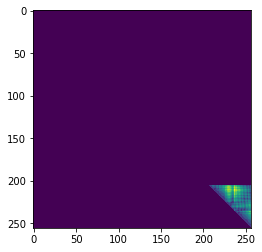

In [8]:
# demonstrate the gif function

gif_from_tri("1hzfA0",chip_diagonal(50,1,256),"chiptri_diag")

In [ ]:
# demonstrate how to create a dataset from it

dataset=pandas.concat([(diag_chips_to_df(pid,10,1)) for pid in pdb_list_y[0:10]])
compute_majority_ss(dataset)

dataset
# dataset.to_csv("datasets/protein_test_fifteen_gt.csv")

In [10]:
# this will add majority secondary structure to the dataframe
# through loading it from file
# i've dummied it out through the if statement but its still usefull
if False:
    dataset=pandas.read_csv("datasets/protein_full_gt.csv")

    compute_majority_ss(dataset)
    dataset.to_csv("datasets/protein_full_gt_classed.csv")



In [11]:
# these generate triangular numbers from a row number
# and row numbers from a triangular number
# not sure if I use them anymore but here they are
def tri_num(x):
    return x*(x+1)/2
    
def inv_tri_num(x):
    for i in range(0,x):
        if tri_num(i)>x:
            return None
        if tri_num(i)==x:
            return i    

In [68]:
# this draws a gif from a number of chips l
# which will iterate through the rows of a datafile
# and make each row (and the chip represented by that row)
# into a frame of the gif
def gif_from_chips(dataset,l,filename):    

    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]
    
    gif=[]

    for n in range(0,l):
        
        chpx=list(df.iloc[n,:])

        chip_l=inv_tri_num(ncol)+1
        chp_im=np.zeros((chip_l,chip_l))
        triu=np.triu_indices(chip_l,1)
        tri_ind=[(triu[0][i],triu[1][i]) for i in range(0,len(triu[0]))]

        for i in range(0,len(tri_ind)):
             chp_im[tri_ind[i][0],tri_ind[i][1]]=chpx[i]

        im=plt.imshow(chp_im)    

        
        x=im.make_image("AGG")[0]
        x=np.flipud(x)

        gif.append(np.array(x))

    imageio.mimsave(filename+'.gif', gif, fps=60)

    
    
# this is a function which will draw the average chip
# of a dataset
# i.e. draw a chip whose pixels are each an average of the
# pixels in that position on each chip
def draw_avg_chip(dataset, name, max_dist):
    
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]

    chpx=list(df.mean(0))
    
#     print(ncol)
    chip_l=inv_tri_num(ncol)+1
    chp_im=np.zeros((chip_l,chip_l))
    triu=np.triu_indices(chip_l,1)
    tri_ind=[(triu[0][i],triu[1][i]) for i in range(0,len(triu[0]))]
    
    for i in range(0,len(tri_ind)):
         chp_im[tri_ind[i][0],tri_ind[i][1]]=chpx[i]

    im=plt.imshow(chp_im,vmax=max_dist)
    
    x=im.make_image("AGG")[0]
    x=np.flipud(x)
    
    imageio.imsave("plots/"+name+".png", x)
    
# as above, but draws a lineplot instead of a chip
def draw_avg_dist_lineplot(dataset, name,max_dist):
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]

    chpx=list(df.mean(0))
    
    chip_l=inv_tri_num(ncol)+1
    chp_im=np.empty((chip_l,chip_l))
    chp_im[:]=np.nan
    chp_im[:,0]=0
    triu=np.triu_indices(chip_l,1)
    tri_ind=[(triu[0][i],triu[1][i]) for i in range(0,len(triu[0]))]
    
    
    for i in range(0,len(tri_ind)):
         chp_im[tri_ind[i][0],tri_ind[i][1]-tri_ind[i][0]]=chpx[i]

    plt.ylim((0, max_dist))
    plt.plot(np.nanmean(chp_im,0))
    
    plt.savefig("plots/lineg/"+name+".png")
    plt.cla()

# as above, but draws a densityplot instead of a lineplot
def draw_avg_dist_densityplot(dataset, name,max_dist):
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]
    
    chpx=list(df.mean(0))
    
    chip_l=inv_tri_num(ncol)+1
    chp_im=np.empty((chip_l,chip_l))
    chp_im[:]=np.nan
    chp_im[:,0]=0
    triu=np.triu_indices(chip_l,1)
    seq_dist=[triu[1][i]-triu[0][i] for i in range(0,len(triu[0]))]
    
    cx=[]
    cy=[]

    for index, row in df.iterrows():
        for i in range(0,len(seq_dist)):
            cx.append(seq_dist[i])
            cy.append(row[i])

    plt.ylim((0, max_dist))

    plt.hist2d(cx,cy)
 
    plt.savefig("plots/2dhist/"+name+".png")
    plt.cla()
    
    
    # as above, but draws a densityplot which does not have an
    # artificially brightened area for lower amino acid sequence distances
    # because we average across sequence distance per chip
    # before averaging across chips
def draw_avg_dist_densityplot2(dataset, name,max_dist):
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]
        
    chip_l=inv_tri_num(ncol)+1
    chp_im=np.empty((chip_l,chip_l))
    chp_im[:]=np.nan
    chp_im[:,0]=0
    triu=np.triu_indices(chip_l,1)

    tri_ind=[(triu[0][i],triu[1][i]) for i in range(0,len(triu[0]))]
    
    cx=[]
    cy=[]
    
    for index, row in df.iterrows():
        for i in range(0,chip_l):
            chp_im[tri_ind[i][0],tri_ind[i][1]-tri_ind[i][0]]=row[i]
        
        cx+=(list(range(1,chip_l)))
        cy+=list(np.nanmean(chp_im,0))[1:]

    xbins=np.linspace(1,chip_l,chip_l)
    ybins=np.linspace(1,max_dist,chip_l*2)
    

    plt.hist2d(cx,cy,bins = (xbins,ybins))
 
    plt.savefig("plots/2dhist/"+name+".png")
    
def get_avg_distances(dataset):
    ncol=len([c for c in dataset.columns if c[0:5]=="dist_"])
    
    df=dataset[["dist_"+str(x) for x in range(0,ncol)]]

    return(list(df.mean(0)))

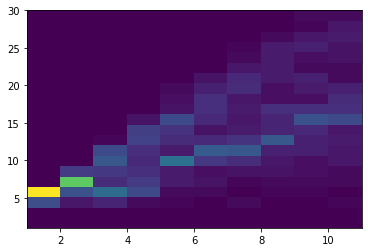

In [47]:
dataset=pandas.read_csv("datasets/protein_test_gt.csv")


draw_avg_dist_densityplot2(dataset.iloc[0:100,:],"test",30)

In [14]:
# read in the dataset to use below
dataset=pandas.read_csv("datasets/protein_test_gt.csv")


# IMPORTANT
# this is the maximum value found in the distance matrix, which lets us
# compare different segmentation-generated avg chips because they all have the same
# color scale (as opposed to the locally normalized color scale used by default)
# max_dist=dataset[["dist_"+str(x) for x in range(0,ncol)]].max().max()
 

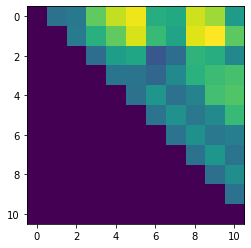

In [15]:
# demonstrate the gif_from_chips function
# which draws an animated gif of a number of chips from a saved dataset

gif_from_chips(dataset,500,"chip_draw")

In [93]:
# this draws the avg distance for each pixel in all chips
# within each point in a thd dendrogram

def draw_thd_segmentations(folder,prefix,dataset):
    tda_dir="datasets/"+folder

    thds=[n for n in os.listdir(tda_dir) if n[0:len(prefix)]==prefix]
        
    df_list=[]
    names=[]
    maxes=[]
    
    for model in thds:
        
        with open(tda_dir+model) as jsonf:
            a=json.load(jsonf)
            
            df=dataset.iloc[[int(m) for m in a['rowList']],:]
            
#             print(model)
#             print([int(m) for m in a['rowList']])
            
            maxes.append(max(get_avg_distances(df)))
            df_list.append(df)
            names.append(model[len(prefix):len(model)-5])
            
    max_dist=max(maxes)
    for i in range(0,len(df_list)):
#         draw_avg_chip(df_list[i],names[i],max_dist)
#         draw_avg_dist_lineplot(df_list[i],names[i],max_dist)
#         draw_avg_dist_densityplot(df_list[i],names[i],max_dist)
        draw_avg_dist_densityplot2(df_list[i],names[i],max_dist)

def thd_row_lengths(folder,prefix):
    tda_dir="datasets/"+folder

    thds=[n for n in os.listdir(tda_dir) if n[0:len(prefix)]==prefix]
    
    d={}
    
    for model in thds:
        
        with open(tda_dir+model) as jsonf:
            a=json.load(jsonf)

            d[model]=a['meta']['row_count']
    
    for i in d:
        print(i +" "+ str(round(d[i]/max(d.values()),2)))

        

In [94]:
# demonstrate draw_thd_segmentations

#     draw_thd_segmentations("thd_test__Absolute Correlation_protein_test_gt_majority.csv_2019.06.18 15.51.08/","thd_test_ ",dataset)
# thd_row_lengths("thd_test__Absolute Correlation_protein_test_gt_majority.csv_2019.06.18 15.51.08/","thd_test_ ")

#     draw_thd_segmentations("THD_test_Absolute Correlation_protein_test_fifteen_gt.csv_2019.06.19 14.20.55/","THD_test ",dataset)

thd_test_ 0.0.0.json 1.0
thd_test_ 1.0.0.json 1.0
thd_test_ 10.0.0.json 0.03
thd_test_ 2.0.0.json 1.0
thd_test_ 3.0.0.json 1.0
thd_test_ 4.0.0.json 0.99
thd_test_ 5.0.0.json 0.83
thd_test_ 5.0.1.json 0.14
thd_test_ 6.0.0.json 0.79
thd_test_ 6.1.1.json 0.07
thd_test_ 7.0.0.json 0.56
thd_test_ 7.0.1.json 0.06
thd_test_ 7.0.2.json 0.02
thd_test_ 7.0.3.json 0.02
thd_test_ 7.0.4.json 0.02
thd_test_ 7.0.5.json 0.01
thd_test_ 8.0.0.json 0.37
thd_test_ 8.0.1.json 0.07
thd_test_ 8.0.2.json 0.04
thd_test_ 8.0.3.json 0.01
thd_test_ 9.0.0.json 0.15
thd_test_ 9.0.1.json 0.11
thd_test_ 9.0.2.json 0.05
thd_test_ 9.0.3.json 0.03


In [133]:
# testing aaron's functions

get_torsion_angles("1a0t")

# ramachandran_plot("1a0t")


# get_pdb_file("1hzf")
# get_secondary_structure("1hzf")

# find_protein_indexes("1hzf")

,Model_Name,Model_ID,Chain,Residue_Name,Residue_ID,Phi,Psi
0,1A0T,0,P,SER,71,NaN,-2.588373
1,1A0T,0,P,GLY,72,-2.262675,-1.972387
2,1A0T,0,P,PHE,73,-1.615826,2.506851
3,1A0T,0,P,GLU,74,-2.448158,2.411354
4,1A0T,0,P,PHE,75,-2.077592,2.054712
5,1A0T,0,P,HIS,76,-2.229607,2.922115
6,1A0T,0,P,GLY,77,2.970213,-3.031954
7,1A0T,0,P,TYR,78,-2.525683,2.591172
8,1A0T,0,P,ALA,79,-2.828566,2.298277
9,1A0T,0,P,ARG,80,-2.227114,2.552979


In [187]:
add_torsion_angles_to_dataframe("1a0t",0,10)

[nan,
 -2.26267468910116,
 -1.6158257601455535,
 -2.448158283287487,
 -2.077592355651276,
 -2.229607215286606,
 2.9702128113188238,
 -2.5256829616336183,
 -2.828565519645726,
 -2.2271139917746803,
 -2.588372634803174,
 -1.9723869060187607,
 2.5068508457835286,
 2.411353862037165,
 2.0547116552024405,
 2.922114713494529,
 -3.031954341435193,
 2.5911719553319865,
 2.2982768204443627,
 2.5529793077642395]

['phi_0',
 'phi_1',
 'phi_2',
 'phi_3',
 'phi_4',
 'phi_5',
 'phi_6',
 'phi_7',
 'phi_8',
 'phi_9']